In [1]:
import numpy as np
from PIL import Image
from package_files.networks import *
from package_files.loss_func import GombinatorialLoss
from package_files.utils import *
import package_files.data_generator as dg
import matplotlib.pyplot as plt
%matplotlib ipympl

from scipy.ndimage import gaussian_filter

In [2]:
# Create dataloaders
images_dir='./MoS2gb_dataset/images'
labels_dir='./MoS2gb_dataset/labels'
train_loader, val_loader, test_loader = get_dataloaders(images_dir, labels_dir, batch_size = 1, val_split=0.2, test_split=0.1)


Train size: 70, Validation size: 20, Test size: 10


In [3]:
# Initialize model
input_channels = 1
num_classes = 6
num_filters = [16, 32, 64, 128, 256]

model = Unet(input_channels, num_classes, num_filters, dropout = 0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss = GombinatorialLoss(group_size = num_classes//2, loss = 'Dice', epsilon=1e-6, class_weights = None)

In [4]:
# Set device
if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps') # backend for Apple silicon GPUs
elif torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [5]:
# Load model weights
path = '/Users/austin/Desktop/Projects/MoS2_gb_Unets/trained_models/GL_norotation_v3_similarity_and_falsepositive_penalty_.pth'
# path = '/Users/austin/Desktop/Projects/MoS2_gb_Unets/trained_models/GL_norotation_v1_64-128-245.pth'
# path = '/Users/austin/Desktop/Projects/Moire_Analysis/trained_models/MoS2gb_model_CELoss.pth'
# path = '/Users/austin/Desktop/Projects/Moire_Analysis/trained_models/MoS2gb_model_CGLoss.pth'
# path = '/Users/austin/Desktop/Projects/Moire_Analysis/trained_models/MoS2gb-ResNet34-Unet'

checkpoint = torch.load(path, map_location=torch.device('mps'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

#model.to(device)
model.eval()



Unet(
  (encoders): ModuleList(
    (0): EncoderBlock(
      (conv_block): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
        )
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): EncoderBlock(
      (conv_block): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1

In [6]:
test_iter = 0

test = test_loader.dataset[test_iter][0].unsqueeze(0)
gt = test_loader.dataset[test_iter][1]

In [7]:
from skimage.filters import threshold_otsu

In [8]:
# Generate prediction
with torch.no_grad():
    #test.to(device)
    probability = model(test)
    prediction = F.sigmoid(probability)#>0.50
probability = probability.squeeze().cpu().numpy() 
prediction = prediction.squeeze().cpu().numpy()

threshold = threshold_otsu(prediction)
prediction = (prediction > threshold).astype(float)


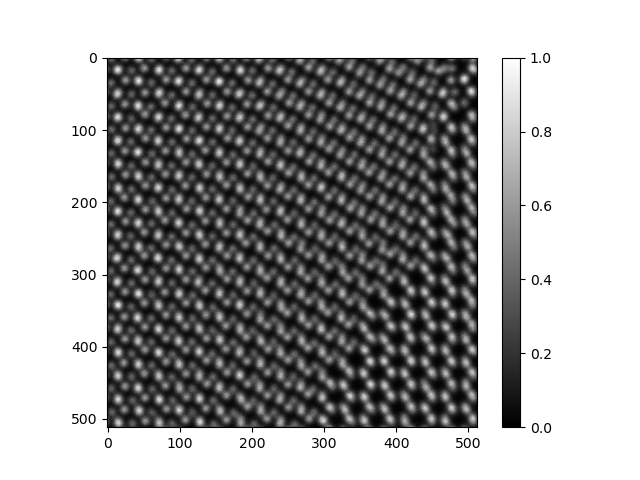

In [11]:
plt.figure()
plt.imshow(test.squeeze().cpu().numpy(), cmap='gray')
plt.colorbar()

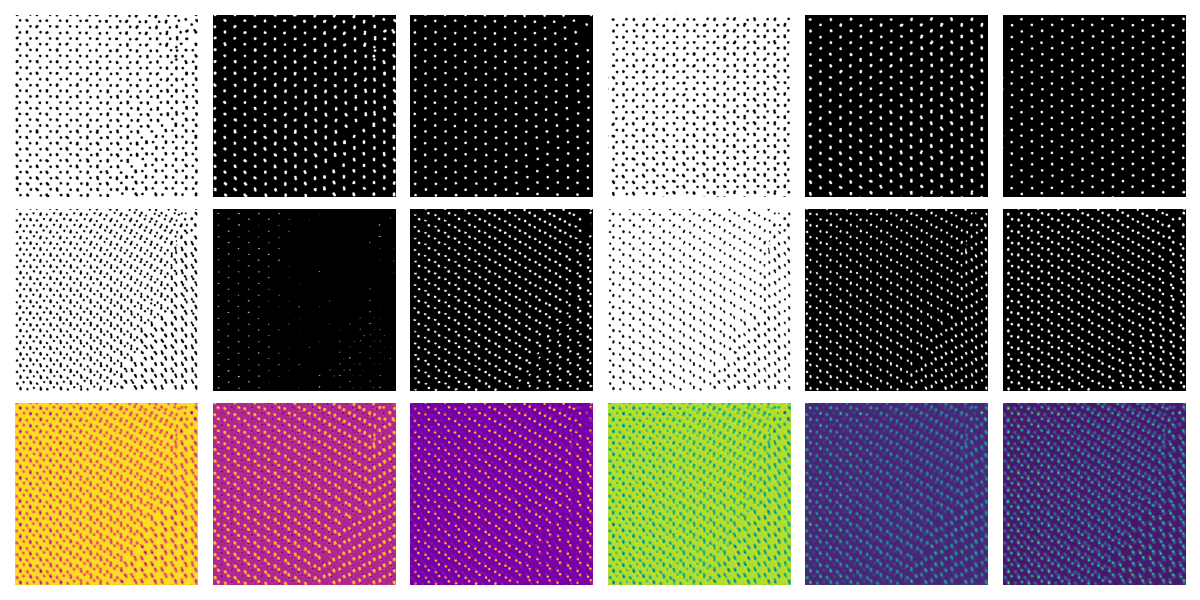

In [10]:
# Plotting
fig, axs = plt.subplots(3,6,figsize=(12, 6), sharex=True, sharey=True)

for i in range(6):
    axs[0,i].imshow(gt[i], cmap='gray')

for i in range(6):
    axs[1,i].imshow(prediction[i], cmap='gray')

for i in range(6)[:3]:
    axs[2,i].imshow(probability[i], cmap='plasma')
for i in range(6)[3:]:
    axs[2,i].imshow(probability[i], cmap='viridis')


for ax in axs.ravel():
    ax.axis('off')

axs[0,0].set_ylabel('GrounTruth')
axs[1,0].set_ylabel('Prediction')
axs[2,0].set_ylabel('Probability')


fig.tight_layout()

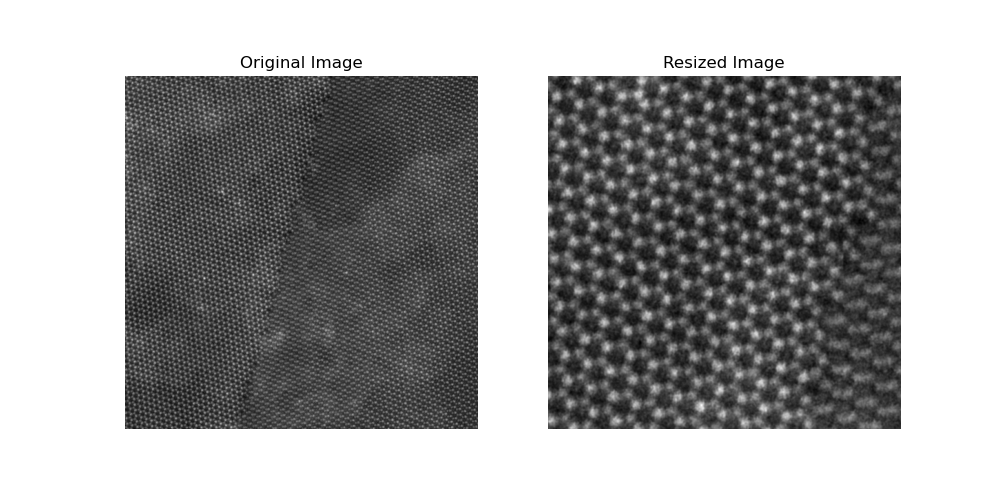

In [ ]:
# Read in the image
#img = Image.open('./expdata/MAADF108.tiff')
img = Image.open('/Users/austin/Desktop/Projects/MoS2_isotope_growth/code/expdata/HAADF115.tiff')
img = np.array(img).astype('float32')
img = img - img.min()
img = img / img.max()
img = gaussian_filter(img, 1)


ims = dg.shotgun_crop(img, crop_size=470, magnification_var = None, n_crops=10, seed=42, return_binary = False, roi = 'middle')
ims = [dg.resize_image(im, 512) for im in ims]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(img, cmap='gray')
ax1.set_title('Original Image')

ax2.imshow(ims[2], cmap='gray')
ax2.set_title('Resized Image')

ax1.axis('off')
ax2.axis('off')

test = torch.Tensor(ims).unsqueeze(1).to(device)

In [108]:
# Generate prediction
with torch.no_grad():
    probability = model(test)
    prediction = F.sigmoid(probability)>0.50
probability = probability.squeeze().cpu().numpy() 
prediction = prediction.squeeze().cpu().numpy()

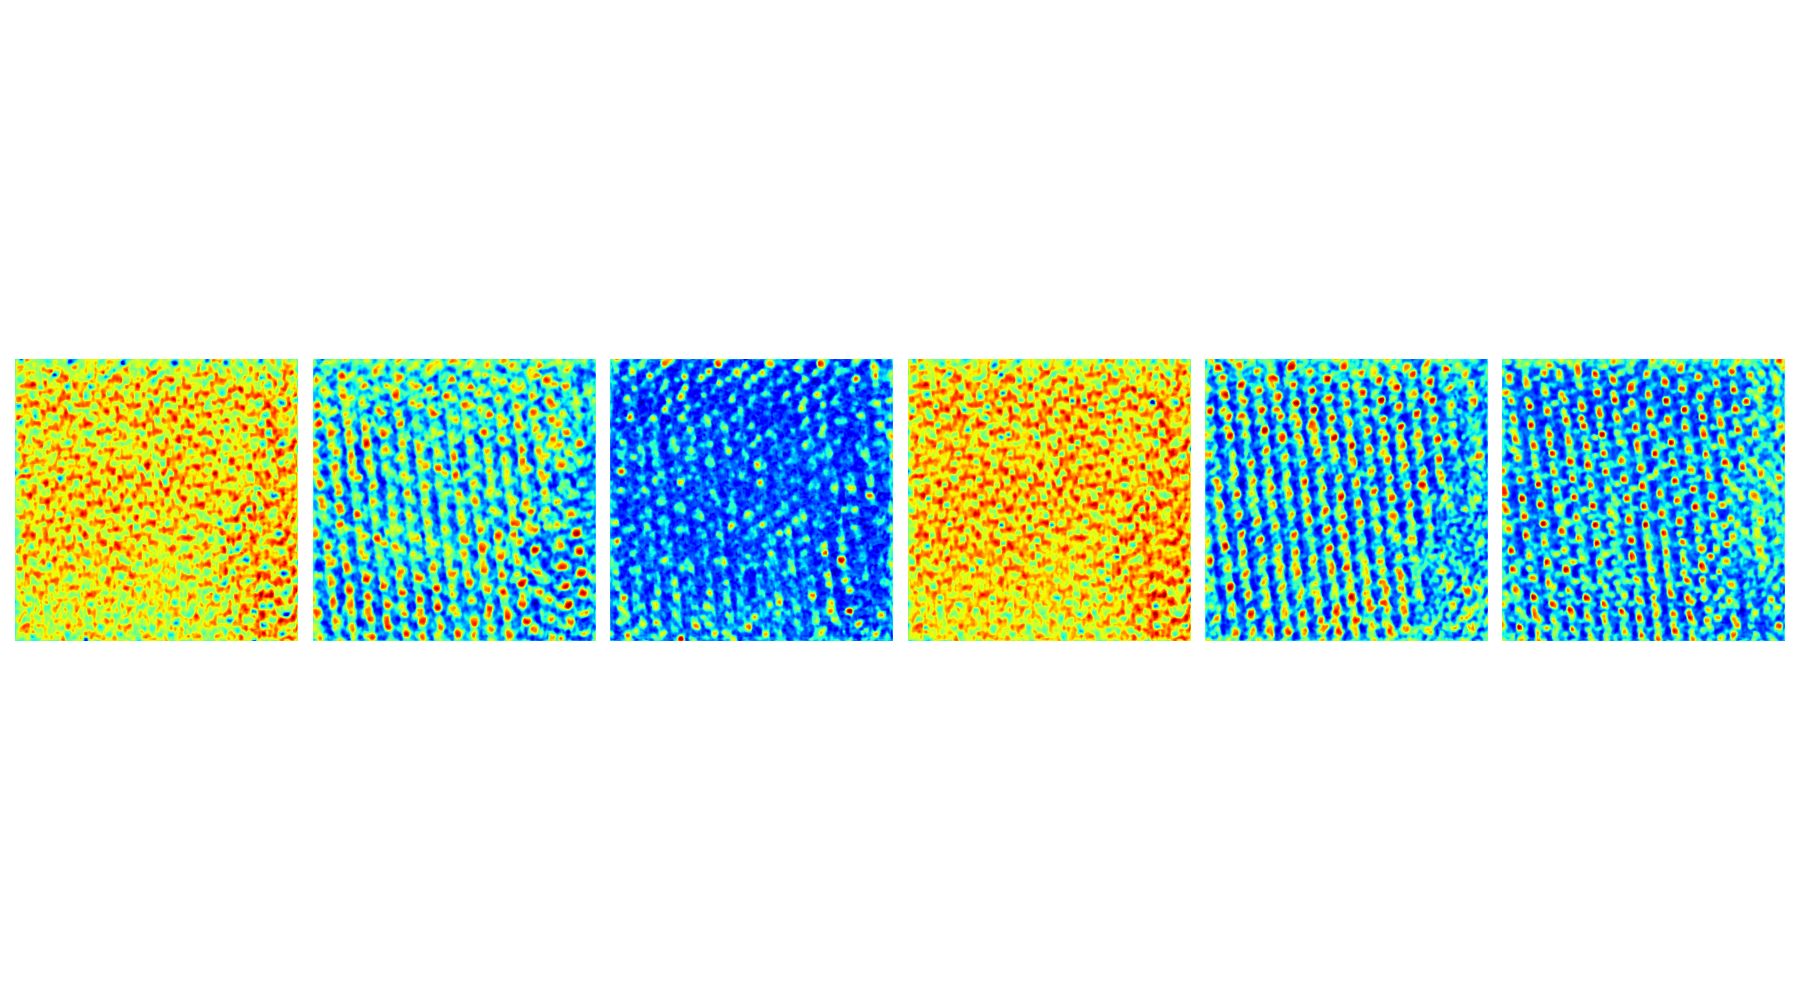

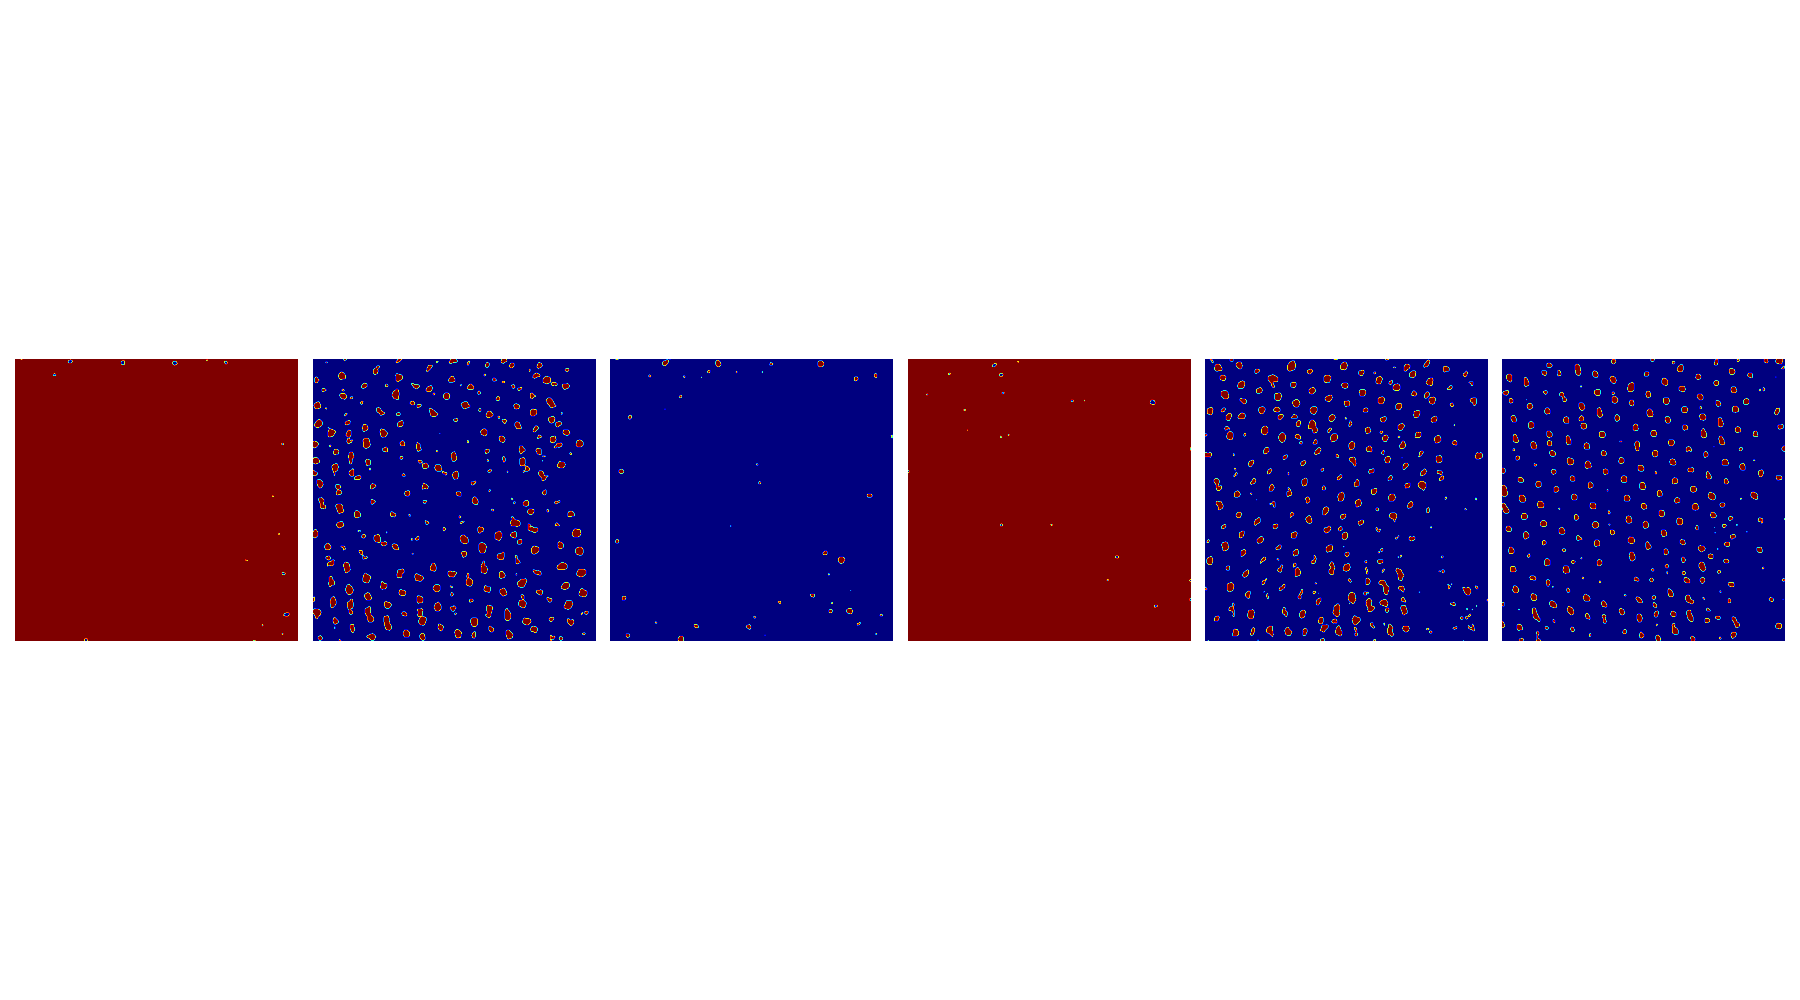

In [109]:
batch = 2
fig, axs = plt.subplots(1,6,figsize=(18, 10), sharex=True, sharey=True)
# Plot each prediction and ground truth
to_plot = range(6)
for i, n in enumerate(to_plot):
    axs[i].imshow(probability[batch,n], cmap='jet')
    axs[i].axis('off')
fig.tight_layout()
fig, axs = plt.subplots(1,6,figsize=(18, 10), sharex=True, sharey=True)
for i, n in enumerate(to_plot):
    axs[i].imshow(prediction[batch,n], cmap='jet')
    axs[i].axis('off')

fig.tight_layout()

In [86]:
prediction = prediction.astype(int)
test_image = test.cpu().squeeze().numpy()



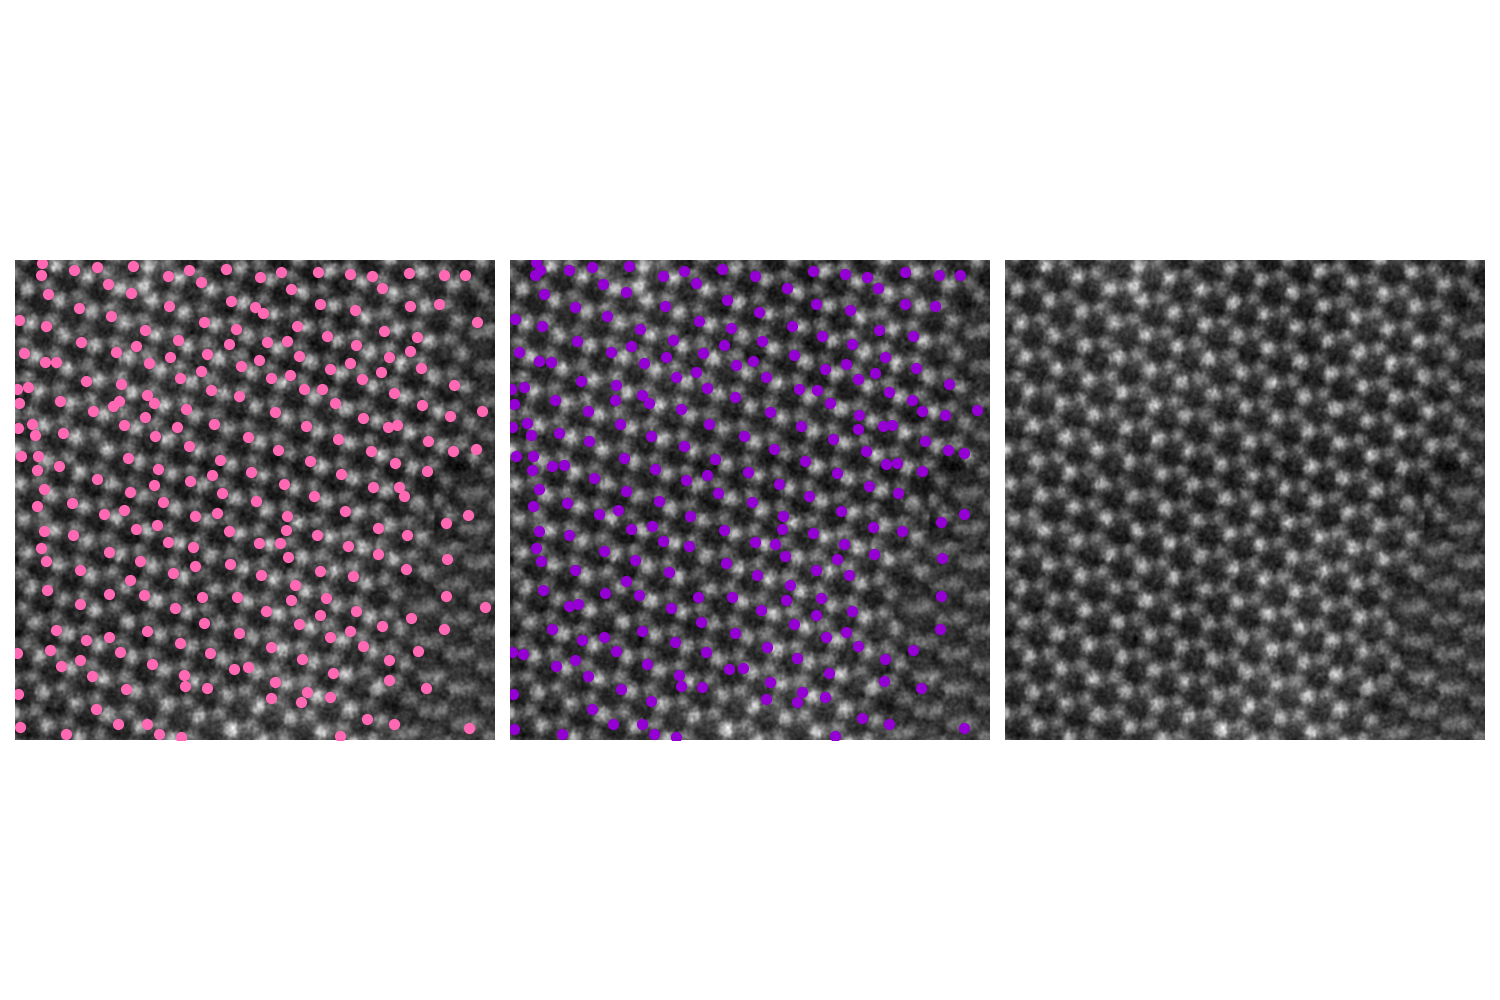

In [91]:
from scipy.ndimage import label, center_of_mass

batch = 2
# make the plots the same size
fig, ax = plt.subplots(1,3,figsize=(15, 10), sharex=True, sharey=True)

threshold_area = 10

atoms = []
layer_indexes = [1,4]
layer_names = ['Mo_A', 'Mo_B']
colors = ['hotpink', 'darkviolet']
for i, n in enumerate(layer_indexes):
    layer = prediction[batch,n]
    labels, num_features = label(layer)

    # filter out small blobs
    for feature_id in range(1, num_features + 1):
        blob_area = (labels == feature_id).sum()
        if blob_area < threshold_area:
            labels[labels == feature_id] = 0

    com = center_of_mass(layer, labels, range(1, num_features+1))
    atoms.append(np.array(com))

    ax[i].imshow(test_image[batch], cmap='gray')
    ax[i].scatter([c[1] for c in com], [c[0] for c in com], color = colors[i], s=50, label = layer_names[i])
    ax[i].axis('off')

ax[2].imshow(test_image[batch], cmap='gray')
ax[2].axis('off')

fig.tight_layout()